# 🌲 Random Forest Models for Drug Sensitivity Prediction

This notebook trains a **Random Forest (RF)** regression model per drug using gene expression features (PCA or HVGs). RFs are robust, handle nonlinearities, and offer good interpretability with minimal hyperparameter tuning. We use **5-fold cross-validation** to evaluate each model’s performance with RMSE and R² metrics.



In [4]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
NUM_PCS = 20

# Choose your dataset (PCA or HVG)
DATA_PATH = "../../../data/processed/bulk_with_pca_tissue_growth.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (566992, 49)


### 🔁 Train One Random Forest Per Drug

For each drug, we train a separate RF model using its associated (cell line, IC50, features) data. We use train-test split and evaluate with RMSE and R².


In [6]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr

# Create result folders
os.makedirs("rf/models", exist_ok=True)
os.makedirs("rf/results", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 100:
        print(f"⚠️ Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values.astype("float64")
    y = df["LN_IC50"].values.astype("float64")

    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        n_jobs=-1,
        random_state=42
    )

    # Perform CV with prediction concatenation
    y_pred = cross_val_predict(model, X, y, cv=kf, n_jobs=-1)

    # Compute metrics
    r2 = r2_score(y, y_pred)
    pearson_r, p_val = pearsonr(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)

    print(f"\n🌲 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ Global R²: {r2:.4f}")
    print(f"  ➤ Pearson r: {pearson_r:.4f} (p={p_val:.2e})")
    print(f"  ➤ RMSE: {rmse:.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "r2_global": r2,
        "pearson_r": pearson_r,
        "pearson_pval": p_val,
        "rmse": rmse
    })

    # Optionally save the last fitted model for this drug on all data
    model.fit(X, y)
    # joblib.dump(model, f"rf/models/rf_drug_{drug_id}.pkl")


🌲 Drug 1 | Samples: 384
  ➤ Global R²: 0.1175
  ➤ Pearson r: 0.3546 (p=8.04e-13)
  ➤ RMSE: 1.0449

🌲 Drug 3 | Samples: 350
  ➤ Global R²: 0.0494
  ➤ Pearson r: 0.2562 (p=1.19e-06)
  ➤ RMSE: 1.9600

🌲 Drug 5 | Samples: 387
  ➤ Global R²: 0.1667
  ➤ Pearson r: 0.4222 (p=3.65e-18)
  ➤ RMSE: 1.5095

🌲 Drug 6 | Samples: 396
  ➤ Global R²: -0.0465
  ➤ Pearson r: 0.1264 (p=1.18e-02)
  ➤ RMSE: 0.9155

🌲 Drug 9 | Samples: 390
  ➤ Global R²: 0.0653
  ➤ Pearson r: 0.2813 (p=1.59e-08)
  ➤ RMSE: 1.4075

🌲 Drug 11 | Samples: 386
  ➤ Global R²: 0.0791
  ➤ Pearson r: 0.2916 (p=5.27e-09)
  ➤ RMSE: 1.8381

🌲 Drug 17 | Samples: 387
  ➤ Global R²: 0.1825
  ➤ Pearson r: 0.4366 (p=1.94e-19)
  ➤ RMSE: 0.8864

🌲 Drug 29 | Samples: 392
  ➤ Global R²: 0.2586
  ➤ Pearson r: 0.5098 (p=2.58e-27)
  ➤ RMSE: 1.5322

🌲 Drug 30 | Samples: 388
  ➤ Global R²: -0.0096
  ➤ Pearson r: 0.1723 (p=6.55e-04)
  ➤ RMSE: 1.2115

🌲 Drug 32 | Samples: 383
  ➤ Global R²: 0.0676
  ➤ Pearson r: 0.2813 (p=2.14e-08)
  ➤ RMSE: 1.8982

🌲 

In [7]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"rf/results/10_fold_.csv", index=False)

print("📁 Saved to rf/results/model_performance_summary.csv")
results_df.head()


📁 Saved to rf/results/model_performance_summary.csv


,DRUG_ID,n_samples,r2_global,pearson_r,pearson_pval,rmse
0,1,384,0.117471,0.354620,8.039103e-13,1.044918
1,3,350,0.049441,0.256222,1.187888e-06,1.960010
2,5,387,0.166730,0.422241,3.646643e-18,1.509534
3,6,396,-0.046534,0.126415,1.180959e-02,0.915529
4,9,390,0.065260,0.281265,1.593330e-08,1.407453


### 📊 Distribution of RF Model Performance
We now visualize the RMSE and R² scores to analyze how well the RF models performed across all drugs.


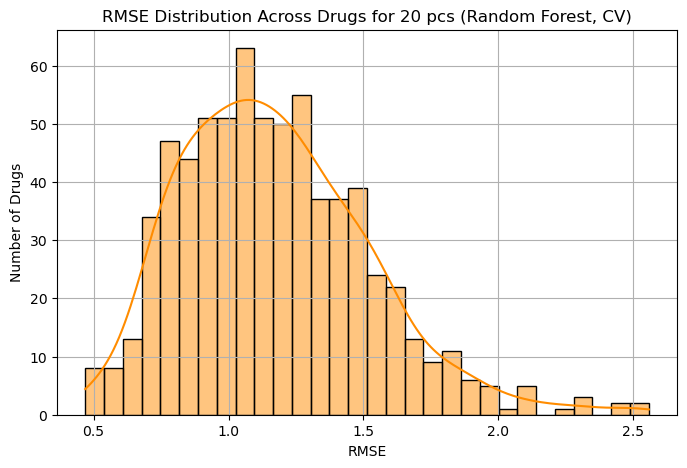

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse"], kde=True, bins=30, color="darkorange")
plt.title(f"RMSE Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

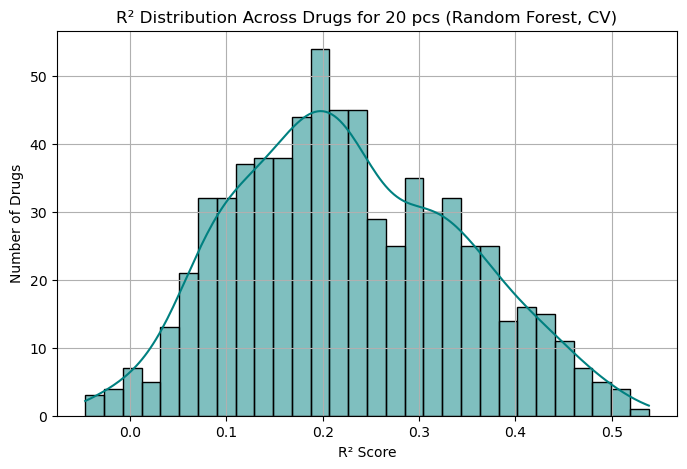

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_global"], kde=True, bins=30, color="teal")
plt.title(f"R² Distribution Across Drugs for {NUM_PCS} pcs (Random Forest, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()

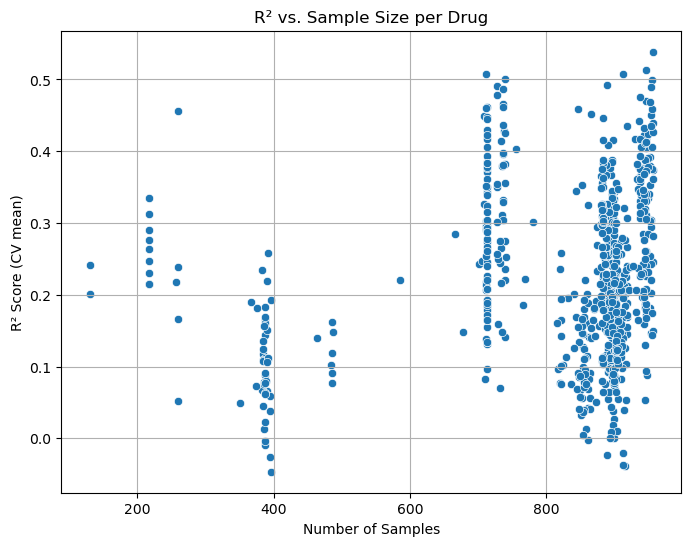

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="n_samples", y="r2_global", data=results_df)
plt.title("R² vs. Sample Size per Drug")
plt.xlabel("Number of Samples")
plt.ylabel("R² Score (CV mean)")
plt.grid(True)
plt.show()


In [13]:
from scipy.stats import pearsonr, spearmanr

# Pearson (linear)
pearson_corr, pval_pearson = pearsonr(results_df["n_samples"], results_df["r2_global"])
print(f"📊 Pearson r = {pearson_corr:.3f} (p = {pval_pearson:.3g})")

# Spearman (rank-based, robust to non-linearities)
spearman_corr, pval_spearman = spearmanr(results_df["n_samples"], results_df["r2_global"])
print(f"📊 Spearman ρ = {spearman_corr:.3f} (p = {pval_spearman:.3g})")


📊 Pearson r = 0.158 (p = 2.83e-05)
📊 Spearman ρ = 0.177 (p = 2.77e-06)


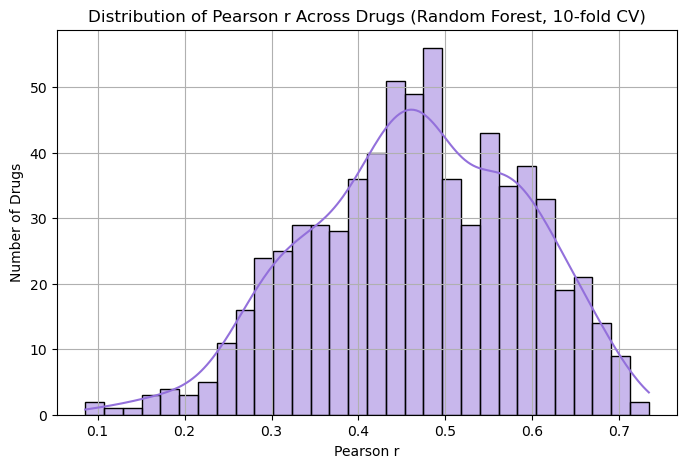

In [16]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["pearson_r"], kde=True, bins=30, color="mediumpurple")
plt.title("Distribution of Pearson r Across Drugs (Random Forest, 10-fold CV)")
plt.xlabel("Pearson r")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()


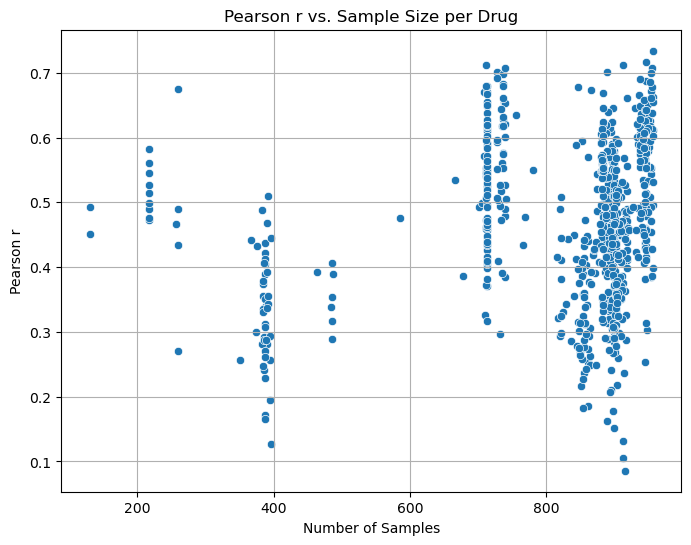

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="n_samples", y="pearson_r")
plt.title("Pearson r vs. Sample Size per Drug")
plt.xlabel("Number of Samples")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()
plt.close()


In [18]:
pearson_corr_r, pval_pearson_r = pearsonr(results_df["n_samples"], results_df["pearson_r"])
spearman_corr_r, pval_spearman_r = spearmanr(results_df["n_samples"], results_df["pearson_r"])

print(f"📊 Pearson r (sample size vs Pearson r) = {pearson_corr_r:.3f} (p = {pval_pearson_r:.3g})")
print(f"📊 Spearman ρ (sample size vs Pearson r) = {spearman_corr_r:.3f} (p = {pval_spearman_r:.3g})")


📊 Pearson r (sample size vs Pearson r) = 0.160 (p = 2.35e-05)
📊 Spearman ρ (sample size vs Pearson r) = 0.176 (p = 3.07e-06)


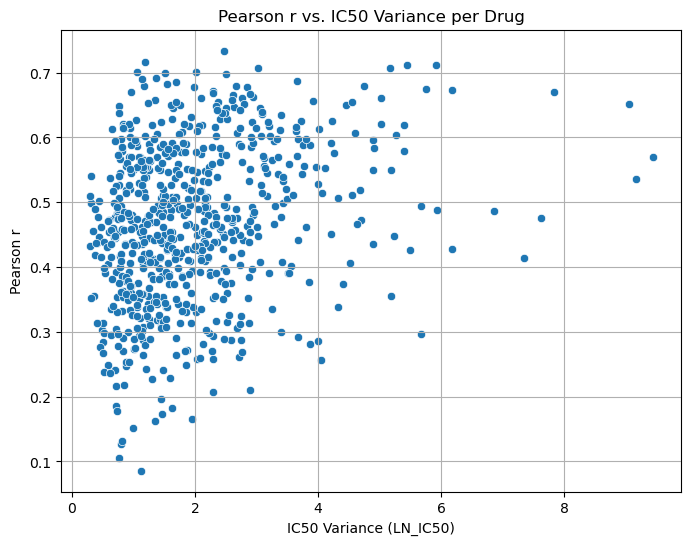

Pearson r (IC50 variance vs Pearson r) = 0.270 (p = 5.02e-13)
Spearman ρ (IC50 variance vs Pearson r) = 0.269 (p = 6.24e-13)


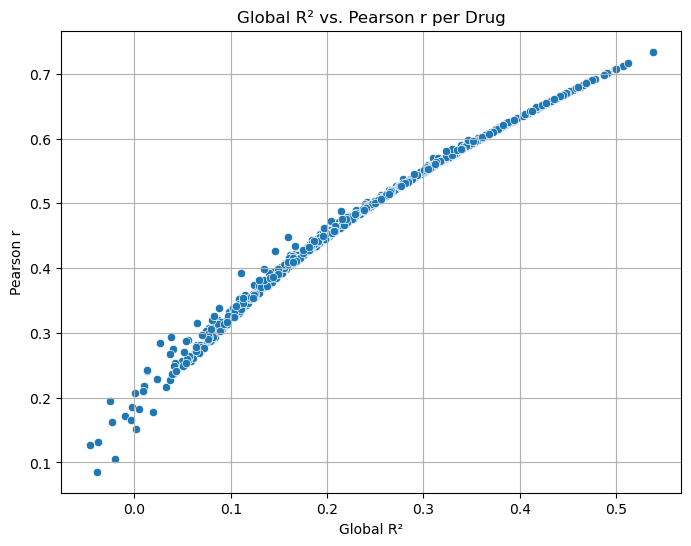


Top 5 drugs by Pearson r:
      DRUG_ID  pearson_r  r2_global      rmse
656     2540   0.733988   0.538552  1.068659
624     2508   0.716071   0.512573  0.761837
528     1845   0.712329   0.507410  1.636718
285     1086   0.712250   0.507184  1.707961
618     2502   0.707217   0.500093  1.605990

Bottom 5 drugs by Pearson r:
      DRUG_ID  pearson_r  r2_global      rmse
240     1023   0.085669  -0.038925  1.078284
278     1072   0.105829  -0.020519  0.881360
3          6   0.126415  -0.046534  0.915529
245     1029   0.131858  -0.037359  0.914142
136      284   0.151208   0.001133  0.994940

Saved top/bottom drugs summary to rf/results/top_bottom_pearson_r.csv

Top 20 features for best drug (2540.0):
 SCF_PC3                               0.281471
day4_day1_ratio                       0.199406
Tissue_Haematopoietic And Lymphoid    0.048480
SCF_PC1                               0.041435
SCF_PC8                               0.027856
SCF_PC21                              0.022048
SCF_PC

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

# ✅ 1) Pearson r vs. IC50 variance
# Already merged? If not, do:
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="pearson_r")
plt.title("Pearson r vs. IC50 Variance per Drug")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()

# Compute correlations
pearson_corr_var, pval_pearson_var = pearsonr(results_df["ic50_variance"], results_df["pearson_r"])
spearman_corr_var, pval_spearman_var = spearmanr(results_df["ic50_variance"], results_df["pearson_r"])
print(f"Pearson r (IC50 variance vs Pearson r) = {pearson_corr_var:.3f} (p = {pval_pearson_var:.3g})")
print(f"Spearman ρ (IC50 variance vs Pearson r) = {spearman_corr_var:.3f} (p = {pval_spearman_var:.3g})")

# ✅ 2) R² vs. Pearson r consistency plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="r2_global", y="pearson_r")
plt.title("Global R² vs. Pearson r per Drug")
plt.xlabel("Global R²")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()

# ✅ 3) Identify top & bottom 5 drugs by Pearson r
top5 = results_df.nlargest(5, "pearson_r")
bottom5 = results_df.nsmallest(5, "pearson_r")
print("\nTop 5 drugs by Pearson r:\n", top5[["DRUG_ID", "pearson_r", "r2_global", "rmse"]])
print("\nBottom 5 drugs by Pearson r:\n", bottom5[["DRUG_ID", "pearson_r", "r2_global", "rmse"]])

# ✅ 4) Optional: Save top/bottom drugs table
top_bottom = pd.concat([top5.assign(rank="top5"), bottom5.assign(rank="bottom5")])
top_bottom.to_csv("rf/results/top_bottom_pearson_r.csv", index=False)
print("\nSaved top/bottom drugs summary to rf/results/top_bottom_pearson_r.csv")

# ✅ 5) Optional: Feature importances for best vs. worst
# Refit models for top & bottom example drugs if needed:
# Example for top drug:
best_drug_id = top5.iloc[0]["DRUG_ID"]
df_best = data[data["DRUG_ID"] == best_drug_id].dropna(subset=["LN_IC50"])
X_best = df_best[gene_cols].values
y_best = df_best["LN_IC50"].values

model_best = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model_best.fit(X_best, y_best)

importances = pd.Series(model_best.feature_importances_, index=gene_cols)
top_genes = importances.sort_values(ascending=False).head(20)
print(f"\nTop 20 features for best drug ({best_drug_id}):\n", top_genes)
top_genes.to_csv(f"rf/results/top_features_drug_{best_drug_id}.csv")
